# Project2 - Bike sharing demand prediction 

###Data Description
See, fork, and run a random forest benchmark model through Kaggle Scripts

You are provided hourly rental data spanning two years. For this project, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.

##Data Fields:

datetime - hourly date + timestamp  

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy

2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist

3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + 
Scattered clouds

4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sn
import missingno as msno
import calendar
import warnings
from datetime import datetime

In [ ]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")

In [ ]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [ ]:
train_data.shape

(10886, 12)

In [ ]:
train_data.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

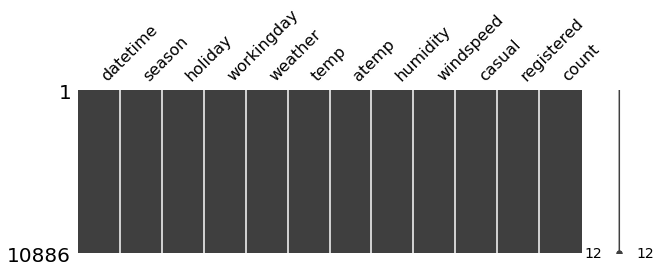

In [ ]:
msno.matrix(train_data, figsize = (10, 3))

## Preprocessing:

In [ ]:
time = []
month = []
day = []
yr = []
for i in train_data['datetime']:
    dt_object2 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    time.append(dt_object2.hour)
    month.append(dt_object2.month)
    day.append(dt_object2.day)
    yr.append(dt_object2.year)

train_data['time'] = pd.DataFrame(time)
train_data['month'] = pd.DataFrame(month)
train_data['day'] = pd.DataFrame(day)
train_data['year'] = yr

train_data['time'] = train_data['time'].astype(float)
train_data['month'] = train_data['month'].astype(float)
train_data['day'] = train_data['day'].astype(float)


In [ ]:
# we wil separaate the date
season_map = {1 : 'spring', 2 : 'summer', 3 : 'fall', 4 : 'winter'}
weather_map = {1 : 'clear + few clouds' + 'partly cloudy',
              2 : 'mist + cloudy, mist + broken clouds, mist + few clouds, mist',
              3 : 'light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds',
              4 : 'heavy rain + ice pallets + thunderstrom + mist, snow + fog'}

In [ ]:
#data['date'] = data.dteday.apply(lambda x: x.split()[0])
#data['weekday'] = data.date.apply(lambda datestring : calendar.day_name[datetime.strptime(datestring, '%Y-%m-%d').weekday()])
train_data['seasons'] = train_data.season.map(season_map)
train_data['weathers'] = train_data.weather.map(weather_map)

In [ ]:
train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,time,month,day,year,seasons,weathers
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy


In [ ]:

print(train_data.seasons.value_counts())
print(train_data.time.value_counts())
print(train_data.weathers.value_counts())
print(train_data.workingday.value_counts())
print(train_data.holiday.value_counts())
print(train_data.month.value_counts())
print(train_data.day.value_counts())
print(train_data.year.value_counts())

winter    2734
fall      2733
summer    2733
spring    2686
Name: seasons, dtype: int64
19.0    456
23.0    456
12.0    456
22.0    456
16.0    456
20.0    456
17.0    456
14.0    456
21.0    456
13.0    456
15.0    456
18.0    456
9.0     455
11.0    455
10.0    455
8.0     455
7.0     455
6.0     455
0.0     455
1.0     454
5.0     452
2.0     448
4.0     442
3.0     433
Name: time, dtype: int64
clear + few cloudspartly cloudy                                                            7192
mist + cloudy, mist + broken clouds, mist + few clouds, mist                               2834
light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds     859
heavy rain + ice pallets + thunderstrom + mist, snow + fog                                    1
Name: weathers, dtype: int64
1    7412
0    3474
Name: workingday, dtype: int64
0    10575
1      311
Name: holiday, dtype: int64
12.0    912
8.0     912
7.0     912
6.0     912
5.0     912
11.0    911
10.0    911
9

## Data Analysis:

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


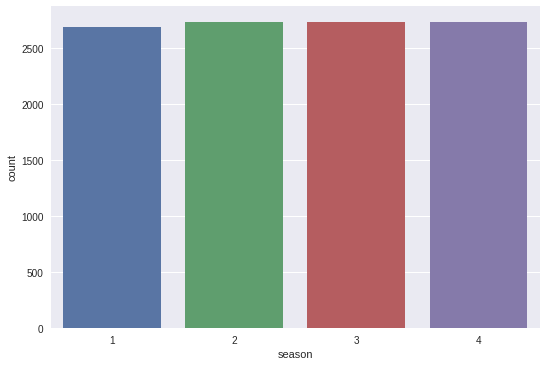

In [ ]:
import seaborn as sns
plt.style.use("seaborn")

sns.factorplot(x='season',data=train_data,kind='count',size=5,aspect=1.5)


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


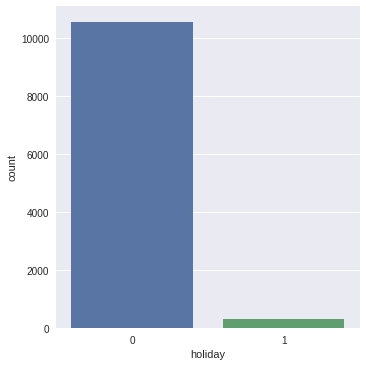

In [ ]:
sns.factorplot(x='holiday',data=train_data,kind='count',size=5,aspect=1) 

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


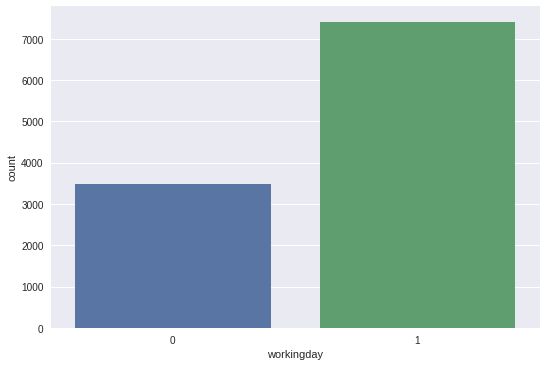

In [ ]:
sns.factorplot(x = 'workingday', data = train_data, kind = 'count', size = 5, aspect = 1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


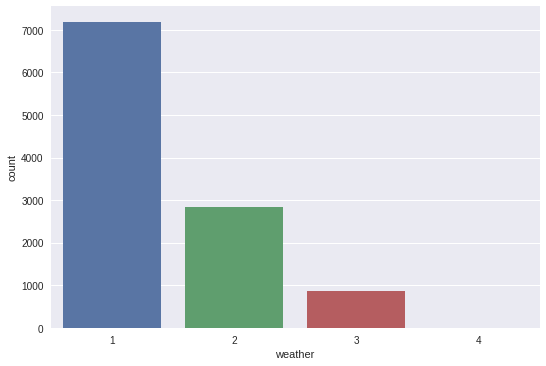

In [ ]:
sns.factorplot(x = 'weather', data = train_data, kind = 'count', size = 5, aspect = 1.5)

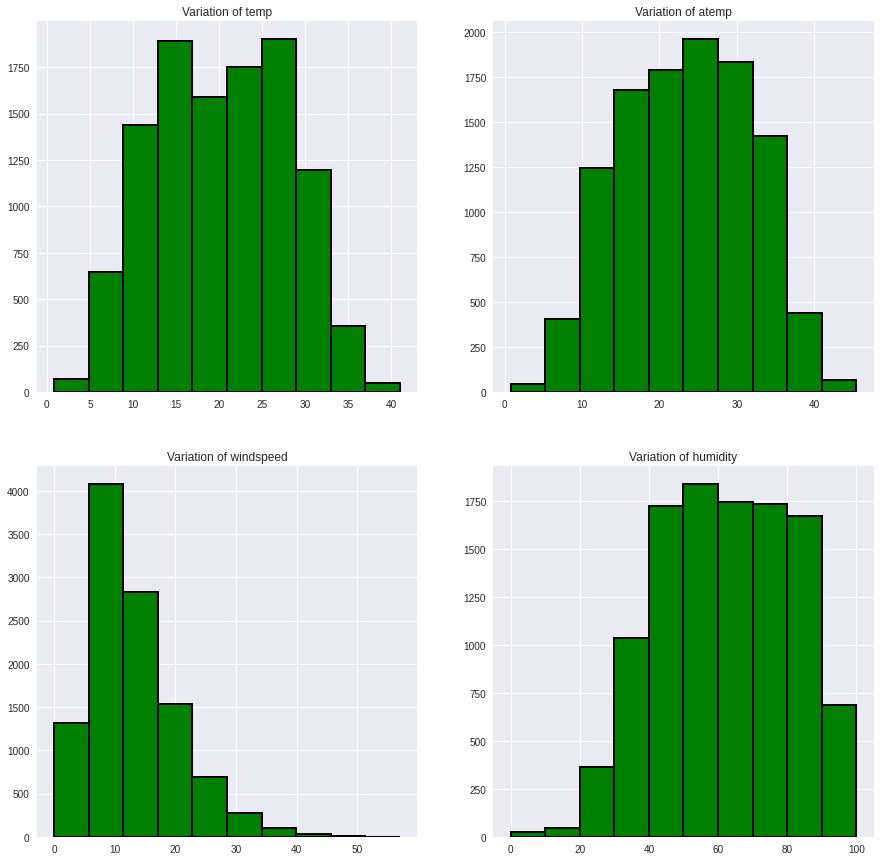

In [ ]:
train_data.temp.unique()

fig,axes=plt.subplots(2,2)

axes[0,0].hist(x="temp",data=train_data,edgecolor="black",linewidth=2,color='green')
axes[0,0].set_title("Variation of temp")

axes[0,1].hist(x="atemp",data=train_data,edgecolor="black",linewidth=2,color='green')
axes[0,1].set_title("Variation of atemp")

axes[1,0].hist(x="windspeed",data=train_data,edgecolor="black",linewidth=2,color='green')
axes[1,0].set_title("Variation of windspeed")

axes[1,1].hist(x="humidity",data=train_data,edgecolor="black",linewidth=2,color='green')
axes[1,1].set_title("Variation of humidity")

fig.set_size_inches(15,15)

In [ ]:
drop_feat = ['datetime', 'season', 'weather']
train_data = train_data.drop(drop_feat, axis = 1)
train_data.head()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,time,month,day,year,seasons,weathers
0,0,0,9.84,14.395,81,0.0,3,13,16,0.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
1,0,0,9.02,13.635,80,0.0,8,32,40,1.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
2,0,0,9.02,13.635,80,0.0,5,27,32,2.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
3,0,0,9.84,14.395,75,0.0,3,10,13,3.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy
4,0,0,9.84,14.395,75,0.0,0,1,1,4.0,1.0,1.0,2011,spring,clear + few cloudspartly cloudy


## Outliers detection and feature engineering:
two types i.e univariate and multivariate. univariate can be detected when we look at the distribution of a single variable. multivariate outliers are outliers in an n dimensional space. in order to find them you have to look at distributions in multiple dimension.

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working day'),
 Text(0.5, 1.0, 'workingday/Count Distribution')]

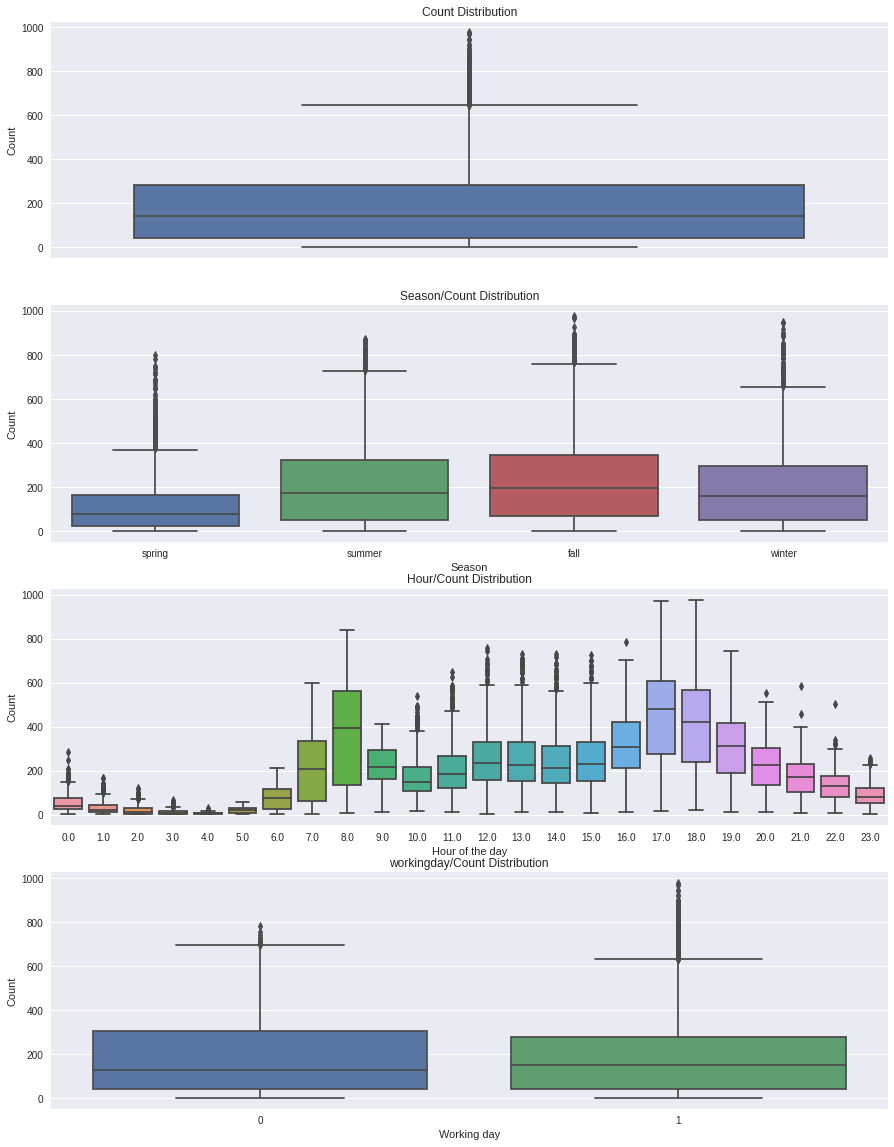

In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 1)
fig.set_size_inches(15,20)                          # creating subplots
                                   
sn.boxplot(data = train_data, y = 'count', orient = 'v', ax = axes[0])
sn.boxplot(data = train_data, y = 'count', x= 'seasons', orient = 'v', ax = axes[1])
sn.boxplot(data = train_data, y = 'count', x= 'time', orient = 'v', ax = axes[2])
sn.boxplot(data = train_data, y = 'count', x= 'workingday', orient = 'v', ax = axes[3])

axes[0].set(ylabel = 'Count', title = 'Count Distribution')
axes[1].set(ylabel = 'Count',xlabel = 'Season', title = 'Season/Count Distribution')
axes[2].set(ylabel = 'Count',xlabel = 'Hour of the day', title = 'Hour/Count Distribution')
axes[3].set(ylabel = 'Count',xlabel = 'Working day', title = 'workingday/Count Distribution')

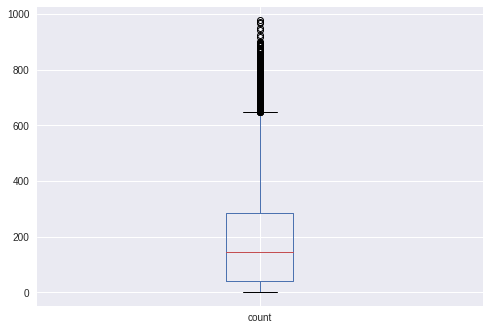

In [ ]:
train_data.boxplot(column = 'count')

In [ ]:
train_data.describe()

,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,time,month,day,year
count,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,0.028569,0.680875,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,11.541613,6.521495,9.992559,2011.501929
std,0.166599,0.466159,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,6.915838,3.444373,5.476608,0.500019
min,0.000000,0.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000
25%,0.000000,0.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,6.000000,4.000000,5.000000,2011.000000
50%,0.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,12.000000,7.000000,10.000000,2012.000000
75%,0.000000,1.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,18.000000,10.000000,15.000000,2012.000000
max,1.000000,1.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,23.000000,12.000000,19.000000,2012.000000


In [ ]:
count_data = pd.DataFrame(train_data['count'])

IQR=count_data.quantile(0.75)-count_data.quantile(0.25)

lower_bridge=count_data.quantile(0.25)-(IQR*1.5)
upper_bridge=count_data.quantile(0.75)+(IQR*1.5)
print(lower_bridge,upper_bridge)

count   -321.0
dtype: float64 count    647.0
dtype: float64


In [ ]:
#### Extreme outliers
extreme_lower_bridge=count_data.quantile(0.25)-(IQR*3)
extreme_upper_bridge=count_data.quantile(0.75)+(IQR*3)
print(extreme_lower_bridge, extreme_upper_bridge)

count   -684.0
dtype: float64 count    1010.0
dtype: float64


In [ ]:
#Lets remove those outliers by using these lower and upper extreme values
#df = data.copy()
#df.loc[df['cnt']>=1004,'cnt']=1004
#df.boxplot(column = 'cnt')

#df = data.copy()
#df.loc[df['cnt']>=643,'cnt']=643
#df.boxplot(column = 'cnt')

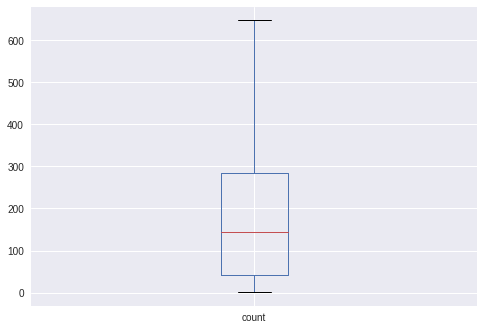

In [ ]:
train_data.loc[train_data['count']>=647, 'count'] = 647
train_data.boxplot(column = 'count')

In [ ]:
train_data['count'].describe()

count    10886.000000
mean       188.704850
std        172.416401
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        647.000000
Name: count, dtype: float64

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working day'),
 Text(0.5, 1.0, 'workingday/Count Distribution')]

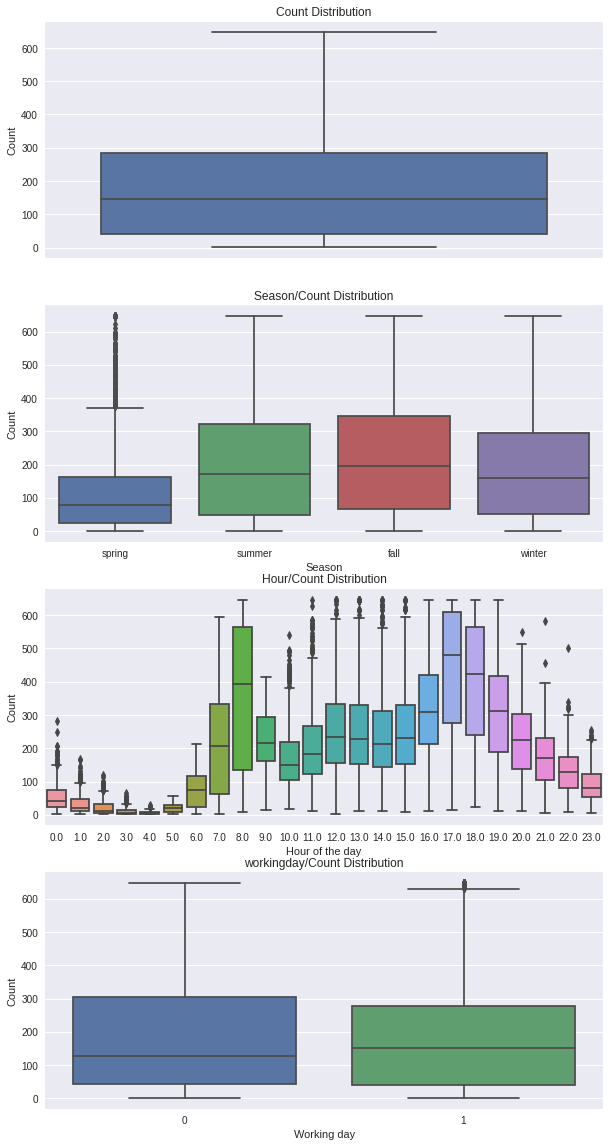

In [ ]:
fig, axes = plt.subplots(nrows = 4, ncols = 1)
fig.set_size_inches(10,20)                          # creating subplots
                                   
sn.boxplot(data = train_data, y = 'count', orient = 'v', ax = axes[0])
sn.boxplot(data = train_data, y = 'count', x= 'seasons', orient = 'v', ax = axes[1])
sn.boxplot(data = train_data, y = 'count', x= 'time', orient = 'v', ax = axes[2])
sn.boxplot(data = train_data, y = 'count', x= 'workingday', orient = 'v', ax = axes[3])

axes[0].set(ylabel = 'Count', title = 'Count Distribution')
axes[1].set(ylabel = 'Count',xlabel = 'Season', title = 'Season/Count Distribution')
axes[2].set(ylabel = 'Count',xlabel = 'Hour of the day', title = 'Hour/Count Distribution')
axes[3].set(ylabel = 'Count',xlabel = 'Working day', title = 'workingday/Count Distribution')

In [ ]:
train_data.columns

Index(['holiday', 'workingday', 'temp', 'atemp', 'humidity', 'windspeed',
       'casual', 'registered', 'count', 'time', 'month', 'day', 'year',
       'seasons', 'weathers'],
      dtype='object')

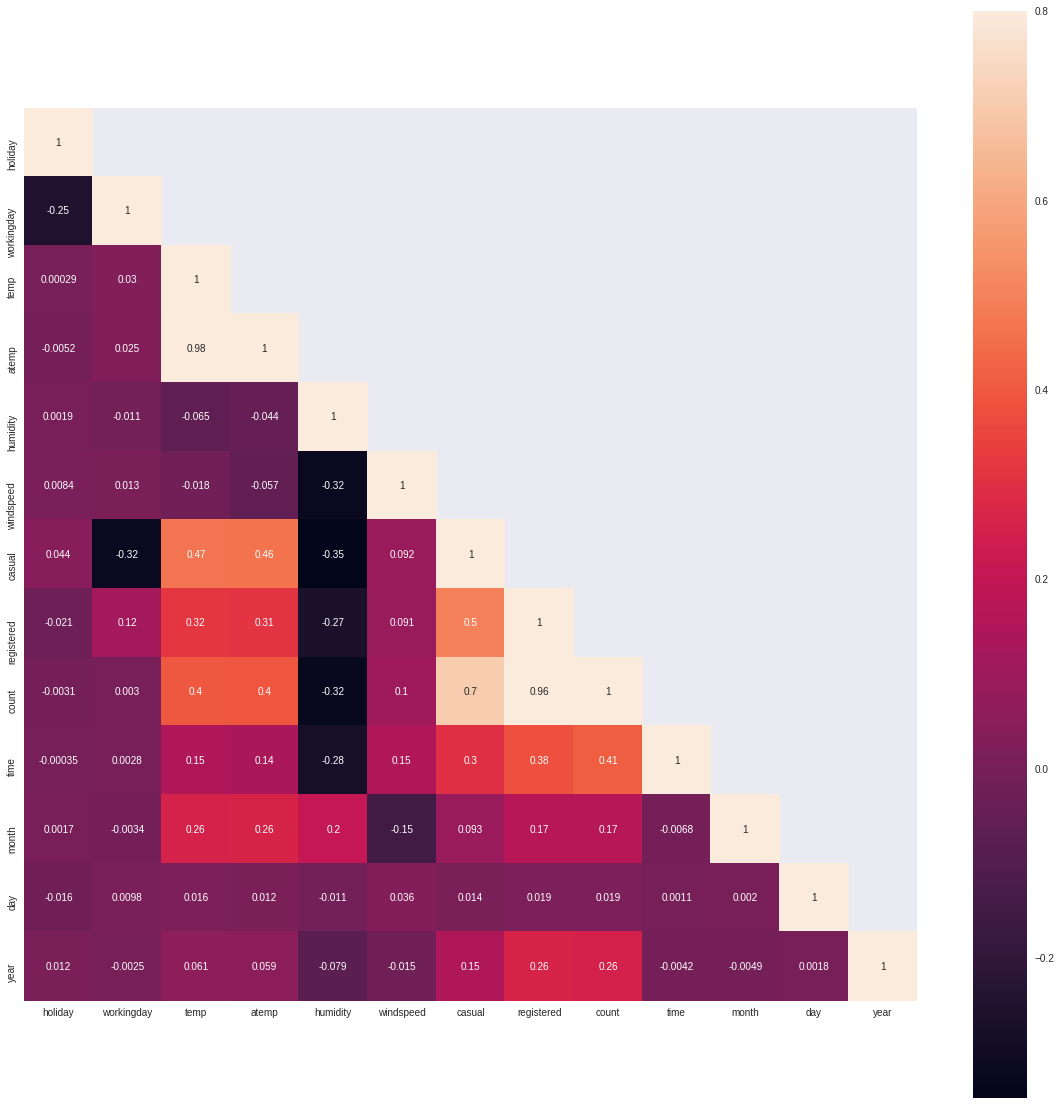

In [ ]:
corr_mat = train_data[:].corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
sn.heatmap(corr_mat, mask = mask, vmax = 0.8, square = True, annot = True)

##Feature engineering from the result of HeatMap:

1.There is a high correlation between count and registered features, temp and atemp features.

2.humidity is inversely related to count as expected as the weather is humid people will not like to travel on a bike, similar for casual and working day.

3.registered/casual and count are highly related which indicates that most of the bikes that are rented are registered.

In [ ]:
season = pd.get_dummies(train_data['seasons'], prefix = 'season')
train_data = pd.concat([train_data, season], axis = 1)

weather = pd.get_dummies(train_data['weathers'], prefix='weather')
train_data = pd.concat([train_data, weather], axis = 1)

drop_features = ['seasons', 'weathers']
train_data = train_data.drop(drop_features, axis = 1)

train_data.head()


,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,time,month,day,year,season_fall,season_spring,season_summer,season_winter,weather_clear + few cloudspartly cloudy,"weather_heavy rain + ice pallets + thunderstrom + mist, snow + fog","weather_light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds","weather_mist + cloudy, mist + broken clouds, mist + few clouds, mist"
0,0,0,9.84,14.395,81,0.0,3,13,16,0.0,1.0,1.0,2011,0,1,0,0,1,0,0,0
1,0,0,9.02,13.635,80,0.0,8,32,40,1.0,1.0,1.0,2011,0,1,0,0,1,0,0,0
2,0,0,9.02,13.635,80,0.0,5,27,32,2.0,1.0,1.0,2011,0,1,0,0,1,0,0,0
3,0,0,9.84,14.395,75,0.0,3,10,13,3.0,1.0,1.0,2011,0,1,0,0,1,0,0,0
4,0,0,9.84,14.395,75,0.0,0,1,1,4.0,1.0,1.0,2011,0,1,0,0,1,0,0,0


In [ ]:
train_data['year'] = train_data['year'].map({2011:0, 2012:1})


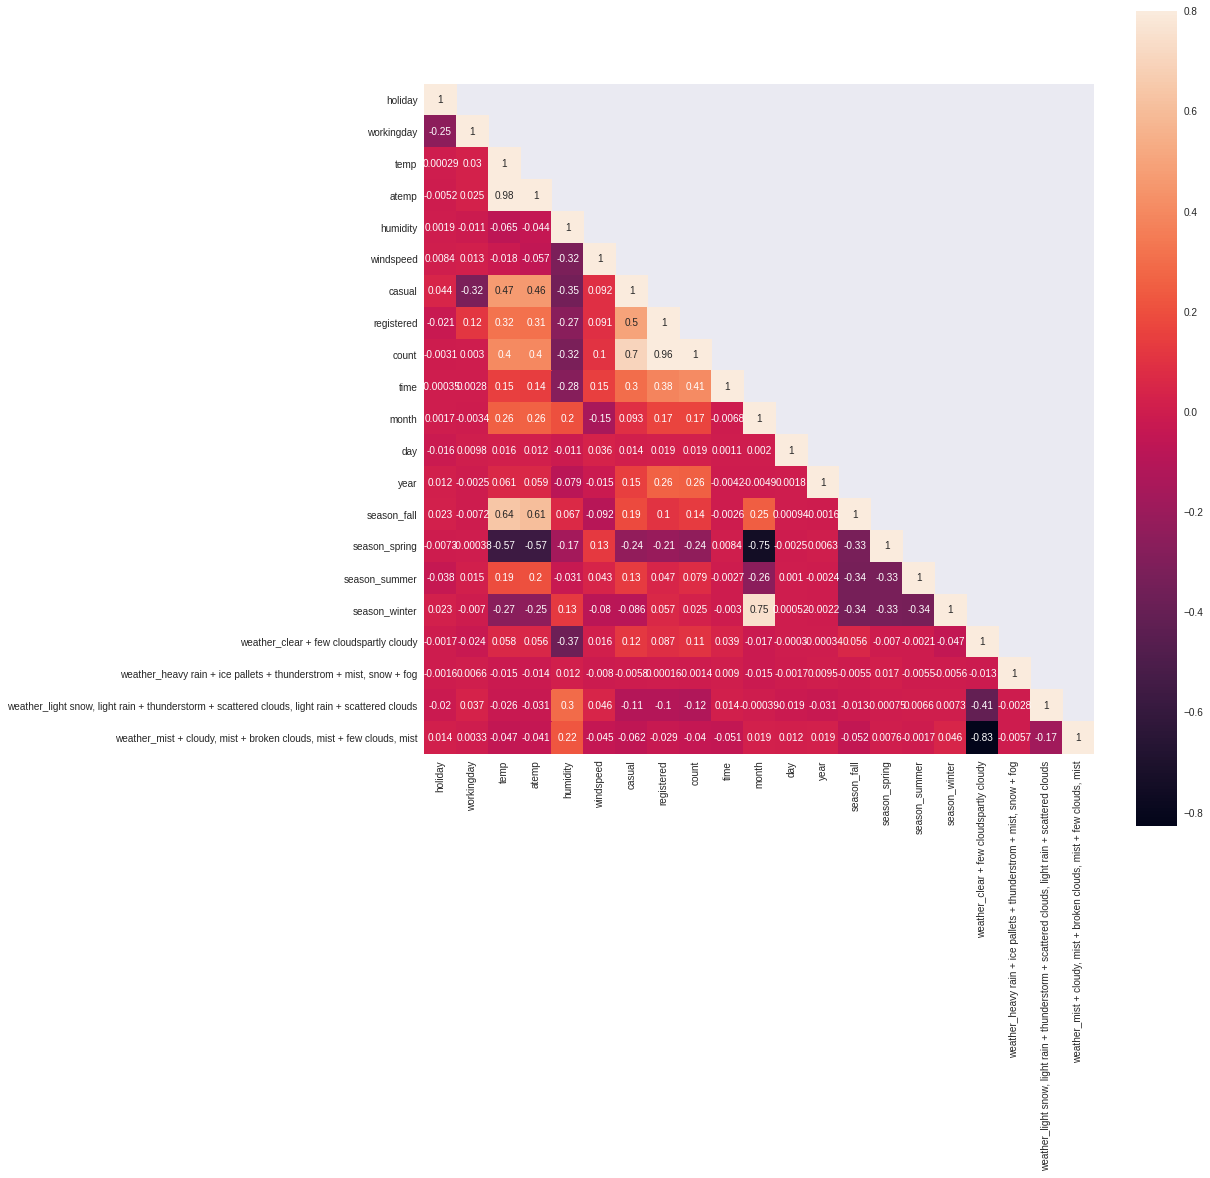

In [ ]:
corr_mat = train_data[:].corr()
mask = np.array(corr_mat)
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
sn.heatmap(corr_mat, mask = mask, vmax = 0.8, square = True, annot = True)

In [ ]:
train_data.drop(['casual', 'registered'], axis = 1, inplace = True)
train_data.head()

,holiday,workingday,temp,atemp,humidity,windspeed,count,time,month,day,year,season_fall,season_spring,season_summer,season_winter,weather_clear + few cloudspartly cloudy,"weather_heavy rain + ice pallets + thunderstrom + mist, snow + fog","weather_light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds","weather_mist + cloudy, mist + broken clouds, mist + few clouds, mist"
0,0,0,9.84,14.395,81,0.0,16,0.0,1.0,1.0,0,0,1,0,0,1,0,0,0
1,0,0,9.02,13.635,80,0.0,40,1.0,1.0,1.0,0,0,1,0,0,1,0,0,0
2,0,0,9.02,13.635,80,0.0,32,2.0,1.0,1.0,0,0,1,0,0,1,0,0,0
3,0,0,9.84,14.395,75,0.0,13,3.0,1.0,1.0,0,0,1,0,0,1,0,0,0
4,0,0,9.84,14.395,75,0.0,1,4.0,1.0,1.0,0,0,1,0,0,1,0,0,0


##Some data analysis using factorplot

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


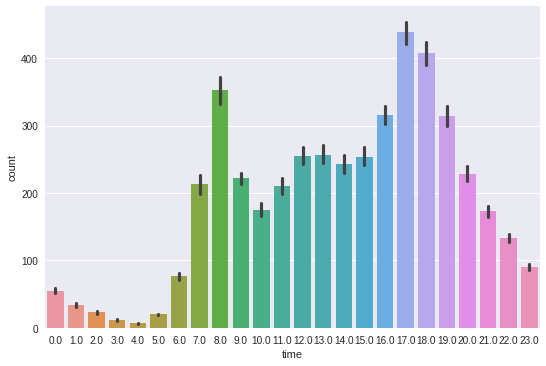

In [ ]:
sns.factorplot(x = 'time', y = 'count', data = train_data, kind = 'bar', size = 5, aspect = 1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


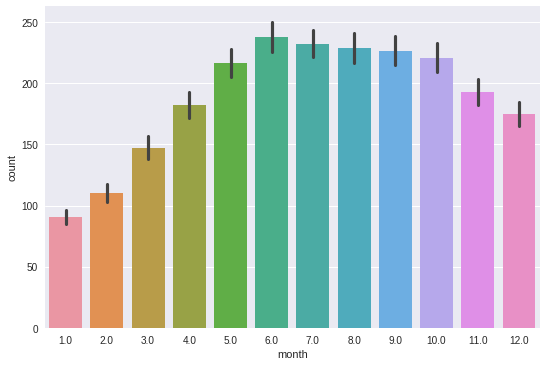

In [ ]:
#count varies according to the month
sns.factorplot(x = 'month', y = 'count', data = train_data, kind = 'bar', size = 5, aspect = 1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


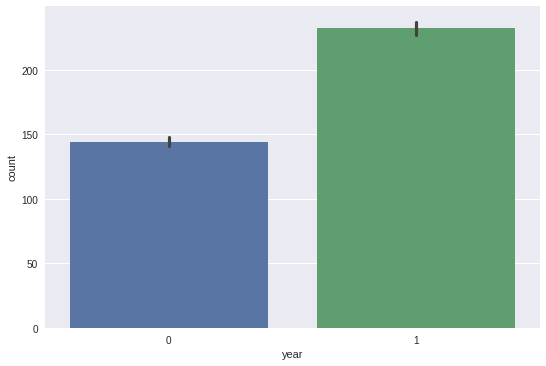

In [ ]:
#count varies according to the year
sns.factorplot(x = 'year', y = 'count', data = train_data, kind = 'bar', size = 5, aspect = 1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


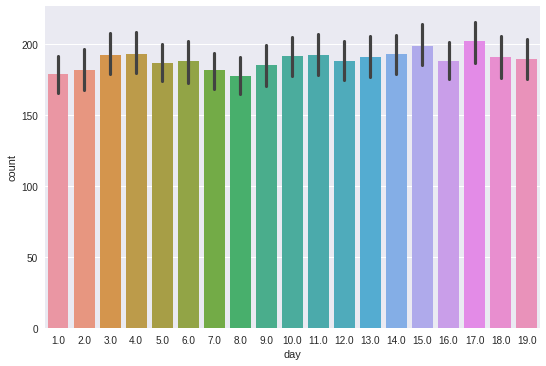

In [ ]:
#count varies according to day
sns.factorplot(x = 'day', y = 'count', data = train_data, kind = 'bar', size = 5, aspect = 1.5)

In [ ]:
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
test_data.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed'],
      dtype='object')

In [ ]:
# similar features we should take into account for the test set
time = []
month = []
day = []
yr = []
for i in test_data['datetime']:
    dt_object2 = datetime.strptime(i, "%Y-%m-%d %H:%M:%S")
    time.append(dt_object2.hour)
    month.append(dt_object2.month)
    day.append(dt_object2.day)
    yr.append(dt_object2.year)

test_data['time'] = pd.DataFrame(time)
test_data['month'] = pd.DataFrame(month)
test_data['day'] = pd.DataFrame(day)
test_data['year'] = yr

test_data['time'] = test_data['time'].astype(float)
test_data['month'] = test_data['month'].astype(float)
test_data['day'] = test_data['day'].astype(float)


test_data['seasons'] = test_data.season.map(season_map)
test_data['weathers'] = test_data.weather.map(weather_map)

drop_feat = ['season', 'weather']
test_data = test_data.drop(drop_feat, axis = 1)

season = pd.get_dummies(test_data['seasons'], prefix = 'season')
test_data = pd.concat([test_data, season], axis = 1)

weather = pd.get_dummies(test_data['weathers'], prefix='weather')
test_data = pd.concat([test_data, weather], axis = 1)

drop_features = ['seasons', 'weathers']
test_data = test_data.drop(drop_features, axis = 1)

test_data['year'] = test_data['year'].map({2011:0, 2012:1})

test_data.head()


,datetime,holiday,workingday,temp,atemp,humidity,windspeed,time,month,day,year,season_fall,season_spring,season_summer,season_winter,weather_clear + few cloudspartly cloudy,"weather_heavy rain + ice pallets + thunderstrom + mist, snow + fog","weather_light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds","weather_mist + cloudy, mist + broken clouds, mist + few clouds, mist"
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,0.0,1.0,20.0,0,0,1,0,0,1,0,0,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1.0,1.0,20.0,0,0,1,0,0,1,0,0,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,2.0,1.0,20.0,0,0,1,0,0,1,0,0,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,3.0,1.0,20.0,0,0,1,0,0,1,0,0,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,4.0,1.0,20.0,0,0,1,0,0,1,0,0,0


## Model Selection:

In [ ]:
from sklearn.model_selection import train_test_split

y = train_data['count']
X = train_data.drop('count', axis = 1)
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size = 0.25, random_state = 99)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

In [ ]:
from sklearn.metrics import mean_squared_log_error

models = [ RandomForestRegressor(), AdaBoostRegressor(), BaggingRegressor(), DecisionTreeRegressor(), KNeighborsRegressor()]

model_names = [ 'Random forest', 'Adaboost', 'Bagging', 'DecisionTree', 'K nearest neighbors', 'Linaer Regression', 'XGBoost', 'SVR']

rmlse = []

result = {}

for model in range(len(models)):
    mod = models[model]
    mod.fit(train_x, train_y)
    pred = mod.predict(test_x)
    print(model)
    rmlse.append(np.sqrt(mean_squared_log_error(pred, test_y)))

#result = {'model names':model_names, 'RMLSE': rmlse}
#result = pd.DataFrame(result)
#result

0
1
2
3
4


In [ ]:
reg_model = LinearRegression()
reg_model.fit(train_x, train_y)
pred_reg = reg_model.predict(test_x)

RSS = np.sum(np.square(test_y - pred_reg))

print(np.sqrt(RSS))

6865.979483949657


In [ ]:
for i in range(len(pred_reg)):
    if pred_reg[i]<0:
        pred_reg[i] = -pred_reg[i]

In [ ]:
rmlse.append(np.sqrt(mean_squared_log_error(test_y, pred_reg)))

In [ ]:
xg_model = XGBRegressor()
xg_model.fit(train_x, train_y)
pred_xg = xg_model.predict(test_x)

for i in range(len(pred_xg)):
    if pred_xg[i]<0:
        pred_xg[i] = -pred_xg[i]

rmlse.append(np.sqrt(mean_squared_log_error(test_y, pred_xg)))

[04:23:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
svm_model = SVR()
svm_model.fit(train_x, train_y)
pred_svm = svm_model.predict(test_x)

for i in range(len(pred_svm)):
    if pred_svm[i]<0:
        pred_svm[i] = -pred_svm[i]

rmlse.append(np.sqrt(mean_squared_log_error(test_y, pred_svm)))

In [ ]:
result = {'model names':model_names, 'RMLSE': rmlse}
result = pd.DataFrame(result)
result

,model names,RMLSE
0,Random forest,0.331366
1,Adaboost,0.942566
2,Bagging,0.343669
3,DecisionTree,0.435247
4,K nearest neighbors,0.918510
5,Linaer Regression,1.194901
6,XGBoost,0.653186
7,SVR,1.125946


## Hyperarameter Optimization:


### Randomized Search CV:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 20)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2', None]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 8, 10, 14]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              }
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 8, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8]}


In [ ]:
rf=RandomForestRegressor()
rf_randomcv=RandomizedSearchCV(estimator=rf,param_distributions=random_grid, n_iter=100, cv=5,verbose=2,
                               random_state=100)
### fit the randomized model
rf_randomcv.fit(train_x,train_y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230, total=   2.3s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230, total=   2.2s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230, total=   2.2s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230, total=   2.2s
[CV] n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230 
[CV]  n_estimators=100, min_samples_split=8, min_samples_leaf=2, max_features=None, max_depth=230, total=   2.2s
[CV] n_estimators=800, min_samples_split=8, min_samples_leaf=2, max_features=auto, max_depth=780 
[CV]  n_estimators=800, min_samples_split=8, min_samples_leaf=2, max_features=auto, max_depth=780, total=  17.6s
[CV] n_estimators=800, min_samples_split=8,

[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed: 123.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
rf_randomcv.best_params_

{'max_depth': 230,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
best_randomcv = rf_randomcv.best_estimator_

In [ ]:
y_pred=best_randomcv.predict(test_x)

np.sqrt(mean_squared_log_error(y_pred, test_y))

0.3319631738504002

###GridSearch CV:

In [ ]:
rf_randomcv.best_params_

{'max_depth': 230,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1000}

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [rf_randomcv.best_params_['max_depth']],
    'max_features': [rf_randomcv.best_params_['max_features']],
    'min_samples_leaf': [rf_randomcv.best_params_['min_samples_leaf'], 
                         rf_randomcv.best_params_['min_samples_leaf']+1, 
                         rf_randomcv.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [rf_randomcv.best_params_['min_samples_split'] - 1,
                          rf_randomcv.best_params_['min_samples_split'], 
                          rf_randomcv.best_params_['min_samples_split'] +1,
                          rf_randomcv.best_params_['min_samples_split'] + 2],
    'n_estimators': [rf_randomcv.best_params_['n_estimators'] - 150, rf_randomcv.best_params_['n_estimators'] - 100, 
                     rf_randomcv.best_params_['n_estimators'] - 50, rf_randomcv.best_params_['n_estimators'], 
                     rf_randomcv.best_params_['n_estimators'] +50, rf_randomcv.best_params_['n_estimators'] + 100, 
                     rf_randomcv.best_params_['n_estimators']+150 , rf_randomcv.best_params_['n_estimators'] + 200]
}

print(param_grid)

{'max_depth': [230], 'max_features': ['auto'], 'min_samples_leaf': [2, 3, 4], 'min_samples_split': [1, 2, 3, 4], 'n_estimators': [850, 900, 950, 1000, 1050, 1100, 1150, 1200]}


In [ ]:
#### Fit the grid_search to the data
grid_search=GridSearchCV(estimator=rf,param_grid=param_grid,cv=10,n_jobs=-1,verbose=2)
grid_search.fit(train_x,train_y)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   14.3s
/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 84.2min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed: 159.9min
[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed: 230.8min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

In [ ]:
grid_search.best_params_

{'max_depth': 230,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [ ]:
best_grid = grid_search.best_estimator_

In [ ]:
y_pred=best_grid.predict(test_x)

np.sqrt(mean_squared_log_error(y_pred, test_y))

0.33223397117583253

### Genetic Algorithms:
Genetic Algorithms tries to apply natural selection mechanisms to Machine Learning contexts.

Let's immagine we create a population of N Machine Learning models with some predifined Hyperparameters. We can then calculate the accuracy of each model and decide to keep just half of the models (the ones that performs best). We can now generate some offsprings having similar Hyperparameters to the ones of the best models so that go get again a population of N models. At this point we can again caltulate the accuracy of each model and repeate the cycle for a definite number of generations. In this way, just the best models will survive at the end of the process.

In [ ]:
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
print(param)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000], 'min_samples_split': [2, 5, 10, 14], 'min_samples_leaf': [1, 2, 4, 6, 8]}


In [ ]:
!pip install tpot

     |████████████████████████████████| 92kB 3.6MB/s 
     |████████████████████████████████| 157.5MB 91kB/s 
     |████████████████████████████████| 163kB 51.8MB/s 
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11954 sha256=f6f9b25fb392bd22de7602480f3e603bddd46f70e35b9f6c2eeb7a875fa05ec8
  Stored in directory: /root/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [ ]:
from tpot import TPOTRegressor


In [ ]:
tpot_regressor = TPOTRegressor(generations= 5, population_size= 24, offspring_size= 12,
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestRegressor': param}, 
                                 cv = 4, scoring = None)
tpot_regressor.fit(train_x,train_y)


Generation 1 - Current best internal CV score: -1906.0713158380333

Generation 2 - Current best internal CV score: -1906.0713158380333

Generation 3 - Current best internal CV score: -1766.7246394699787

Generation 4 - Current best internal CV score: -1766.7246394699787

Generation 5 - Current best internal CV score: -1749.2841785830956

Best pipeline: RandomForestRegressor(RandomForestRegressor(RandomForestRegressor(RandomForestRegressor(input_matrix, max_depth=1000, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=1000), max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=1400), max_depth=120, max_features=log2, min_samples_leaf=4, min_samples_split=10, n_estimators=1200), max_depth=120, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=800)


TPOTRegressor(config_dict={'sklearn.ensemble.RandomForestRegressor': {'max_depth': [10,
                                                                                    120,
                                                                                    230,
                                                                                    340,
                                                                                    450,
                                                                                    560,
                                                                                    670,
                                                                                    780,
                                                                                    890,
                                                                                    1000],
                                                                      'max_features': ['auto',
              

In [ ]:
pred_y = tpot_regressor.predict(test_x)

np.sqrt(mean_squared_log_error(pred_y, test_y))

0.3182198810190708

## Model Deployment on test data:

In [ ]:
test_data.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,time,month,day,year,season_fall,season_spring,season_summer,season_winter,weather_clear + few cloudspartly cloudy,"weather_heavy rain + ice pallets + thunderstrom + mist, snow + fog","weather_light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds","weather_mist + cloudy, mist + broken clouds, mist + few clouds, mist"
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,0.0,1.0,20.0,0,0,1,0,0,1,0,0,0
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1.0,1.0,20.0,0,0,1,0,0,1,0,0,0
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,2.0,1.0,20.0,0,0,1,0,0,1,0,0,0
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,3.0,1.0,20.0,0,0,1,0,0,1,0,0,0
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,4.0,1.0,20.0,0,0,1,0,0,1,0,0,0


In [ ]:
predict_test=tpot_regressor.predict(test_data.drop('datetime',axis=1))

In [ ]:
test_data['count'] = predict_test

test_data.head()

,datetime,holiday,workingday,temp,atemp,humidity,windspeed,time,month,day,year,season_fall,season_spring,season_summer,season_winter,weather_clear + few cloudspartly cloudy,"weather_heavy rain + ice pallets + thunderstrom + mist, snow + fog","weather_light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds","weather_mist + cloudy, mist + broken clouds, mist + few clouds, mist",count
0,2011-01-20 00:00:00,0,1,10.66,11.365,56,26.0027,0.0,1.0,20.0,0,0,1,0,0,1,0,0,0,13.19250
1,2011-01-20 01:00:00,0,1,10.66,13.635,56,0.0000,1.0,1.0,20.0,0,0,1,0,0,1,0,0,0,5.74625
2,2011-01-20 02:00:00,0,1,10.66,13.635,56,0.0000,2.0,1.0,20.0,0,0,1,0,0,1,0,0,0,4.71875
3,2011-01-20 03:00:00,0,1,10.66,12.880,56,11.0014,3.0,1.0,20.0,0,0,1,0,0,1,0,0,0,3.00375
4,2011-01-20 04:00:00,0,1,10.66,12.880,56,11.0014,4.0,1.0,20.0,0,0,1,0,0,1,0,0,0,2.36250


## Analyzing result:

In [ ]:
columns = test_data.columns

In [ ]:
columns

Index(['datetime', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'time', 'month', 'day', 'year', 'season_fall',
       'season_spring', 'season_summer', 'season_winter',
       'weather_clear + few cloudspartly cloudy',
       'weather_heavy rain + ice pallets + thunderstrom + mist, snow + fog',
       'weather_light snow, light rain + thunderstorm + scattered clouds, light rain + scattered clouds',
       'weather_mist + cloudy, mist + broken clouds, mist + few clouds, mist',
       'count'],
      dtype='object')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


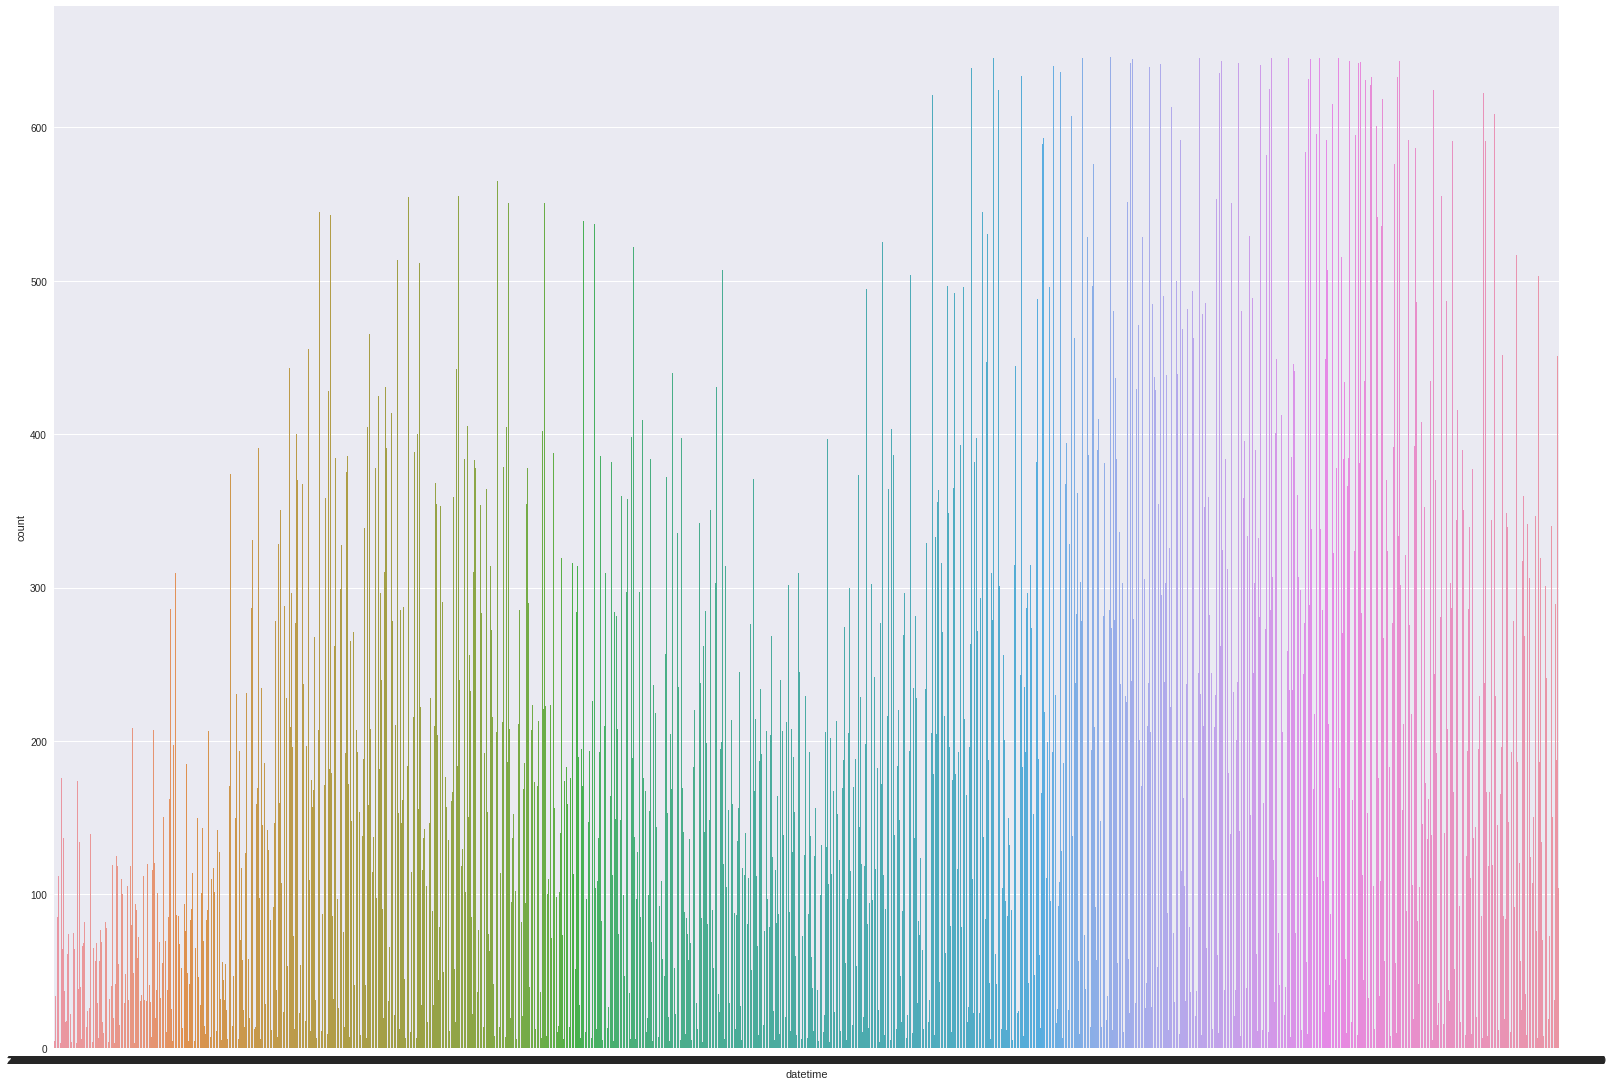

In [ ]:

features = columns[:-1]
target = columns[-1]

sns.factorplot(x = 'datetime', y = target, data = test_data, kind = 'bar', size = 15, aspect = 1.5)

##Save result:

In [ ]:
test_data = pd.read_csv('test.csv')
test_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [ ]:
data={'datetime':test_data['datetime'],
      'season': test_data['season'],
      'holiday': test_data['holiday'],
      'workingday	':test_data['workingday'],
      'weather': test_data['weather'],
      'temp':test_data['temp'],
      'atemp':test_data['atemp'],
      'humidity':test_data['humidity'],
      'windspeed':test_data['windspeed'],
      'count':predict_test}

ans=pd.DataFrame(data)
ans.to_csv('answer.csv',index=False) # saving to a csv file for pred